#### This code generates large dataframe containing multiple timeseries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

#### parameters to set

In [2]:
n_series = 6
n_timesteps = 8*24*3600 # 8 days

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

#### generate normal data

In [3]:
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df[s]=pd.Series(v)
df['Flag']=0
#df.head()

#### generate anomalies

In [4]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = (n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    for s in affects:
        df.loc[start:end,s] = df.loc[start:end,s] + random.random() * 0.3
    if len(affects)>1:
        df.loc[start:end,"Flag"]=1
        

#### enforce range

In [5]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

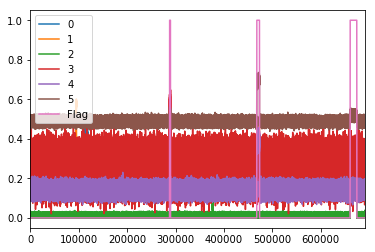

In [6]:
df.plot()

#### running BDT

In [7]:
clf = AdaBoostClassifier(n_estimators=100)
# y=df.Flag
# X=df.loc[:,range(n_series)]
# scores = cross_val_score(clf, X, y)
# print(scores)

#### separate data into Reference and Subject

In [8]:
reference = df[:n_timesteps/4] #reference data refers to the data collected from the first 2 days
reference.loc[:].Flag = 0 # Flagging the reference data as 0
X_ref = reference.loc[:, range(n_series)] #refers to the feature set data
y_ref = reference.Flag #refers to the label data
subject = df[n_timesteps-3600:] #subject data refers to the data collected from the last hour
subject.loc[:].Flag = 1 # Flagging the subject data as 1
X_sub = subject.loc[:, range(n_series)] #refers to the feature set data
y_sub = subject.Flag #refers to the label data

/Users/jameszhang/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### separate Reference and Subject into Train and Test

In [9]:
refTrainSize = reference.shape[0] * 0.7 #training size of reference data is 70% of the data
X_ref_train = X_ref.loc[:refTrainSize, range(n_series)] #take 70% of the reference feature data
X_ref_test  = X_ref.loc[refTrainSize:, range(n_series)] #take 30% of the reference feature data
y_ref_train = y_ref.loc[:refTrainSize] #take 70% of the reference label data
y_ref_test  = y_ref.loc[refTrainSize:] #take 30% of the reference label data

subTrainSize = subject.shape[0] * 0.7 #training size of subject data is 70% of the data
X_sub_train = subject.loc[:subTrainSize, range(n_series)] #take 70% of the subject feature data
X_sub_test  = subject.loc[subTrainSize:, range(n_series)] #take 30% of the subject feature data
y_sub_train = y_sub.loc[:subTrainSize] #take 70% of the subject label data
y_sub_test  = y_sub.loc[subTrainSize:] #take 30% of the subject label data

#### Combine reference and subject train and test datasets

In [10]:
X_train_frames = [X_ref_train, X_sub_train] 
X_train = pd.concat(X_train_frames) #combine the 70% training data features from both reference and subject
y_train_frames = [y_ref_train, y_sub_train]
y_train = pd.concat(y_train_frames) #combine the 70% training data label from both reference and subject

X_test_frames = [X_ref_test, X_sub_test]
X_test = pd.concat(X_test_frames) #combine the 30% training data features from both reference and subject
y_test_frames = [y_ref_test, y_sub_test]
y_test = pd.concat(y_test_frames) #combine the 30% training data label from both reference and subject

#### Train model using the combined train data

In [15]:
clf.fit(X_train, y_train) 
#train an AdaBoost model to be able to tell the difference between the reference and subject data

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

#### Predict using the combined test data

In [16]:
y_predict = clf.predict(X_test)
#use the trained AdaBoost model on the testing data. This is the predicted result

#### Calculate AUC

In [17]:
from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

# convert False and True to 0 and 1
#lb = LabelBinarizer()
#y_test_transformed = lb.fit_transform(y_test)
#y_predict_transformed = lb.fit_transform(y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
auc_score = auc(fpr, tpr) #calculate the AUC score
print auc_score #finds the auc score. If auc~.5, then no anomalies. If auc>0.5, then there are anomalies

0.5


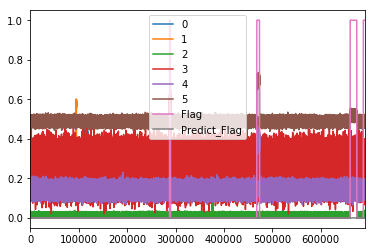

In [18]:
X=df.loc[:,range(n_series)] # get all the features
y_predict = clf.predict(X)  # predict whole list of Flags
y_predict_df = pd.DataFrame(y_predict, columns=['Predict_Flag']) #label my predicted anomalies
# X_test_reset_index = X_test.reset_index(drop=True)
x_y_combined = pd.concat([df, y_predict_df], axis=1) #append the column to the right of the original table
x_y_combined.plot()